In [1]:
!pip install scikit-image==0.16.2


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
import skimage
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)          # limit GPU memory

from keras import backend as K
K.clear_session()                   # disallocate GPU memory

In [3]:
# class that defines and loads the firearm dataset
class FirearmsDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir):
        # define classes
        self.add_class("dataset", 1, "Handgun")
        self.add_class("dataset", 2, "Rifle")
        # define data locations
        images_dir = dataset_dir
        annotations_dir = 'FDENS/mock_attack_sevilla/annotations/'
             
            
		# find all images
        for filename in listdir(images_dir):
            #print(filename)
			# extract image id
            image_id = filename[:-4]
			#print('IMAGE ID: ',image_id)
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids = [0,1,2])


	# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
		# load and parse the file
        tree = ElementTree.parse(filename)
		# get the root of the document
        root = tree.getroot()
		# extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text   #Add label name to the box list
            xmin = int(float(box.find('./bndbox/xmin').text))
            ymin = int(float(box.find('./bndbox/ymin').text))
            xmax = int(float(box.find('./bndbox/xmax').text))
            ymax = int(float(box.find('./bndbox/ymax').text))
            coors = [xmin, ymin, xmax, ymax, name]
            
            boxes.append(coors)
		# extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    
	# load the masks for an image
    def load_mask(self, image_id):
		# get details of image
        info = self.image_info[image_id]
		# define box file location
        path = info['annotation']
        #return info, path
        
        
		# load XML
        boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            
            
            # box[4] will have the name of the class 
            if (box[4] == 'Handgun'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Handgun'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Rifle')) 
          
        return masks, asarray(class_ids, dtype='int32')
        

	# load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [4]:
# train set
train_dir='FDENS/mock_attack_sevilla/train/'
train_set = FirearmsDataset()
train_set.load_dataset(train_dir)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_dir='FDENS/mock_attack_sevilla/test/'
test_set = FirearmsDataset()
test_set.load_dataset(test_dir)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 1638
Test: 3511



*** No instances to display *** 



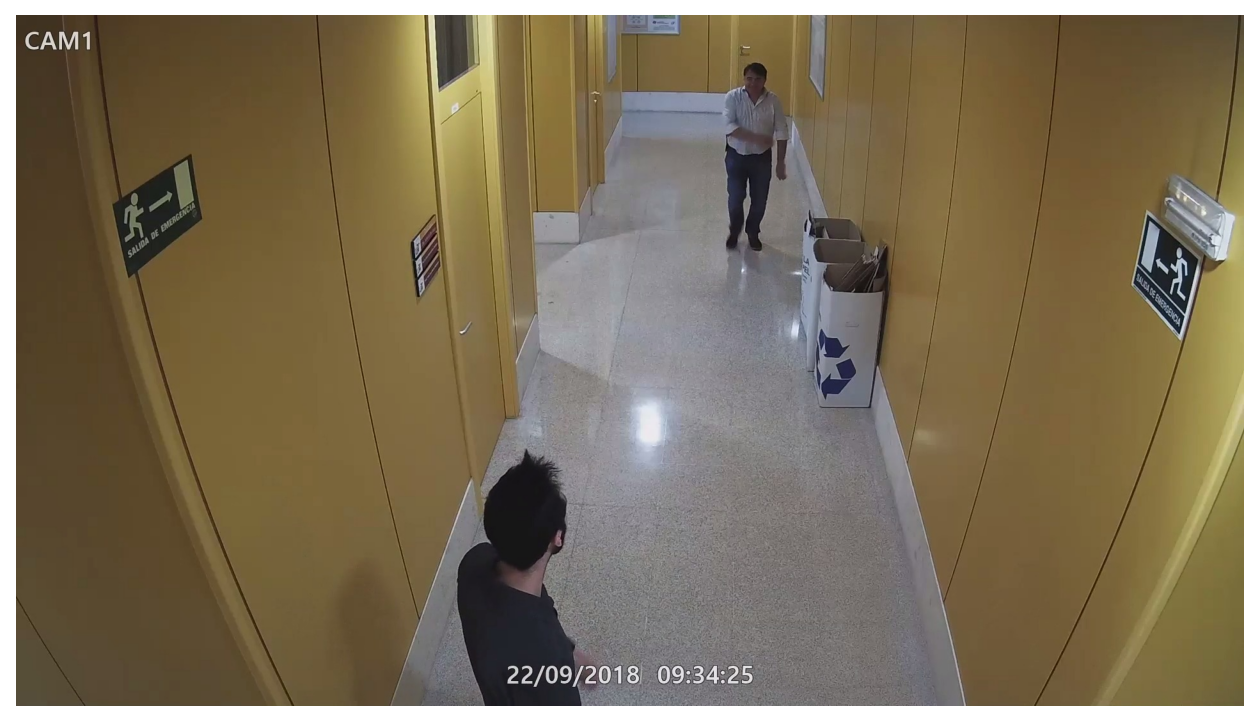

In [5]:
import random
num=random.randint(0, len(train_set.image_ids))
# define image id
image_id = num
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [6]:
# define a configuration for the model
class FirearmsConfig(Config):
	# define the name of the configuration
	NAME = "firearms_cfg"
	# number of classes (background + 2 detected classes (Handgun + Rifle))
	NUM_CLASSES = 1 + 2
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
	IMAGES_PER_GPU = 1

In [7]:
# prepare config
config = FirearmsConfig()
config.display()

import os
ROOT_DIR = os.path.abspath("./")
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
print(ROOT_DIR)
print(DEFAULT_LOGS_DIR)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
# define the model
model = MaskRCNN(mode='training', model_dir="logs", config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights("mask_rcnn_coco/mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=15, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: logs/firearms_cfg20230219T0654/mask_rcnn_firearms_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDis

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", shape=(Non

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 10.4560 - rpn_class_loss: 1.1104 - rpn_bbox_loss: 8.9465 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.0521

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100/100 [==============================] - 78s 501ms/step - batch: 49.5000 - size: 1.0000 - loss: 10.4560 - rpn_class_loss: 1.1104 - rpn_bbox_loss: 8.9465 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.0521 - val_loss: 5.3874 - val_rpn_class_loss: 0.2692 - val_rpn_bbox_loss: 5.1182 - val_mrcnn_class_loss: 1.1921e-07 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/15
100/100 [==============================] - 31s 310ms/step - batch: 49.5000 - size: 1.0000 - loss: 6.4369 - rpn_class_loss: 0.4783 - rpn_bbox_loss: 4.4782 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 1.3283 - mrcnn_mask_loss: 0.1319 - val_loss: 5.0219 - val_rpn_class_loss: 0.6044 - val_rpn_bbox_loss: 4.4175 - val_mrcnn_class_loss: 3.1700e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/15
100/100 [==============================] - 31s 311ms/step - batch: 49.5000 - size: 1.0000 - loss: 5.9101 - rpn_class_loss: 0.6379 - rpn_bbox_loss: 3.6749

In [9]:
model.keras_model.save_weights('FDENS/weights/fdens_mask_rcnn.h5')

In [10]:
#model.keras_model.summary()
model.keras_model.history.history

{'loss': [10.455956327915192,
  6.436860716342926,
  5.910073824524879,
  3.8211888766288755,
  3.770241174697876,
  3.1158608850836753,
  3.127437361180782,
  3.338441408276558,
  2.5952657783031463,
  2.2835505996644496,
  2.3383068761229513,
  1.848628890812397,
  2.0455108976364134,
  2.1485108813643454,
  1.7728950136899948],
 'rpn_class_loss': [1.1104247570037842,
  0.47833213210105896,
  0.6379173994064331,
  0.2504553496837616,
  0.2066185623407364,
  0.23241063952445984,
  0.19892394542694092,
  0.3304521143436432,
  0.2106306254863739,
  0.16337919235229492,
  0.28021666407585144,
  0.2193145751953125,
  0.21881268918514252,
  0.2190093845129013,
  0.20392417907714844],
 'rpn_bbox_loss': [8.946463584899902,
  4.47822380065918,
  3.67490816116333,
  1.4792355298995972,
  1.316042423248291,
  1.1336342096328735,
  1.1408799886703491,
  1.3093552589416504,
  1.2383954524993896,
  1.100074291229248,
  1.4411622285842896,
  0.9564900398254395,
  1.091802954673767,
  1.157170772552

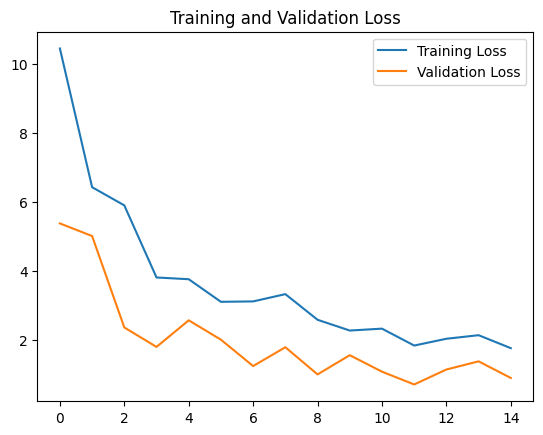

In [11]:
loss = model.keras_model.history.history['loss']
val_loss = model.keras_model.history.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(0,15)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
from matplotlib.patches import Rectangle

# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "firearms_cfg"
	# number of classes (background + 2 detected classes (handgun + rifle))
	NUM_CLASSES = 1 + 2
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
    
predcfg = PredictionConfig()

In [13]:
# Load model in inference mode
inf_mod = MaskRCNN(mode="inference", model_dir='FDENS/weights/', config=predcfg)
inf_mod.load_weights('FDENS/weights/fdens_mask_rcnn.h5', by_name=True)

Instructions for updating:
Use fn_output_signature instead


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


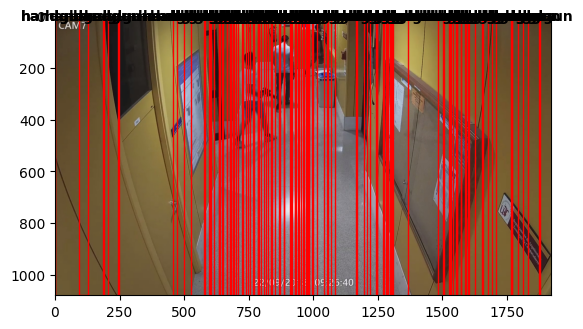

In [14]:
#Test on a single image
num=random.randint(0, len(test_set.image_ids))
# define image id
image_id = num
# load the image
#gun_img = test_set.load_image(image_id)
gun_img = skimage.io.imread("FDENS/mock_attack_sevilla/test/Cam7-From09-05-50To10-09-24_Segment_8_x264_frame_57.jpg")
# #Download a new image for testing...
# #https://c2.peakpx.com/wallpaper/603/971/645/fruit-fruit-bowl-fruits-apple-wallpaper-preview.jpg
detected = inf_mod.detect([gun_img])[0]
pyplot.imshow(gun_img)
ax = pyplot.gca()
class_names = ['handgun', 'rifle']
class_id_counter=1
for box in detected['rois']:
    #print(box)
#get coordinates
    detected_class_id = detected['class_ids'][class_id_counter-1]
    #print(detected_class_id)
    #print("Detected class is :", class_names[detected_class_id-1])
    y1, x1, y2, x2 = box
    #calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    #create the shape
    ax.annotate(class_names[detected_class_id-1], (x1, y1), color='black', weight='bold', fontsize=10, ha='center', va='center')
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
#draw the box
    ax.add_patch(rect)
    class_id_counter+=1
#show the figure
pyplot.show()